<a href="https://colab.research.google.com/github/hasan-sh/advanced-nlp/blob/main/Firstmodel_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

THINGS TO DO:
deal with NER ,
 add model1 as feature, 
 use weighted average,
 morphtype (could extract feature ahhh thats what hisha, was saying)

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [2]:
!git clone https://github.com/hasan-sh/advanced-nlp.git

fatal: destination path 'advanced-nlp' already exists and is not an empty directory.


In [3]:
!pwd

/content


In [4]:
train_file = '/content/advanced-nlp/data/en_ewt-up-train.conllu'
test_file = '/content/advanced-nlp/data/en_ewt-up-test.conllu'

In [5]:
def read_data(file_path, save_to_csv=False):
    """
    This function reads a CoNLL-U format file and converts it into a pandas DataFrame.
    Each row in the DataFrame corresponds to a token in the file, and columns
    correspond to different features of the token, such as the token itself, its lemma, 
    part-of-speech tag, and syntactic dependency information.
    
    Parameters:
    file_path (str): The path to the input CoNLL-U format file.
    save_to_csv (bool): A boolean flag indicating whether to save the resulting DataFrame 
                        to a CSV file. Default is False.
                        
    Returns:
    df (pandas.DataFrame): A pandas DataFrame containing the token-level information from
                           the input file.
    """
    
    # Open and read the input file
    with open(file_path, 'r', encoding='utf-8') as f:
        train_data = f.read()
    
    # Split the file into individual documents, each separated by a blank line
    data = []
    for doc_i, doc in enumerate(train_data.split('\n\n')):
        doc = doc.split('\n')
        sentences = ''
        for line in doc:
            # Skip lines starting with '#' (comment lines)
            if line and line[0] != '#':
                line = line.split('\t')
                line.insert(0, str(doc_i))
                sentences += '\t'.join(line) + '\n'
        data.append(sentences)
    
    # Create a pandas DataFrame from the token-level data
    train_df = pd.DataFrame([x.split('\t') for sent in data for x in sent.split('\n') if x])
    
    # Rename the columns of the DataFrame
    train_df = train_df.rename(columns={
        0:'sent_id', 
        1:'token_id', 
        2:'token', 
        3:'lemma', 
        4:'POS', 
        5:'uni_POS',
        6:'morph_type', 
        7:'distance_head', 
        8:'dep_label', 
        9:'dep_rel', 
        10:'space', 
        11:'probbank'
    })
    
    # Convert the DataFrame from wide to long format
    df = train_df.melt(
        id_vars=[i for i in train_df.columns[:12]], 
        var_name="notneeded", 
        value_name="target"
    )
    
    # Drop the 'notneeded' column and any rows that contain missing values
    #df["sent_id"]=df['sent_id'].str.cat((df['notneeded'].astype(int)-12).astype(str) , sep="_" )
    df["repetion_id"]=df["notneeded"]-12
    df.drop(['notneeded'], axis=1, inplace=True)
    df = df[df['target'].notna()]
    
    # Optionally save the resulting DataFrame to a CSV file
    if save_to_csv:
        df.to_csv('/content/advanced-nlp/data/test.tsv', sep='\t', index=False)
    
    # Return the resulting DataFrame

    return df

In [6]:
train = read_data(train_file,save_to_csv=True)
test = read_data(test_file, save_to_csv=True)

In [7]:
def make_binary_label(df):
  df = df.assign(label=[0 if target=="_" or target=="V" else 1 for target in df['target']])
  #df= df.drop('target', axis=1)
  return df




#clean column
def columns_cleaning(df): #political choices inside
  """This function perform a preprocessing steps that consists of:
  - in removing rows with missinvg value for distance head feature
  - cast numerical features to int 
  - drop token_id (I belive is useless)
  

  """
  df=df[df["distance_head"]!="_"]#like this
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
  
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE

  df= df.drop('token_id', axis=1) #or this
  df=df[['sent_id', 'repetion_id','token', 'lemma', 'POS', 'uni_POS', 'morph_type',
        'distance_head', 'dep_label', 'dep_rel', 'space', 'probbank' ,'label']]

  return df


def make_NER(df):
  return df


"""cols_to_encode=[ 'token', 'lemma', 'POS', 'uni_POS',
       'morph_type', 'dep_label', 'dep_rel', 'space',
       'probbank']"""

"""cols_to_encode=[ 'POS', 'uni_POS',
       'morph_type', 'dep_label', 'dep_rel', 'space',
       'probbank']"""


def create_ORD_encoding(train_df,test_df,cols_to_encode):
  """This function creates a ordinal encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a Encoder objec
  oe = OrdinalEncoder(handle_unknown='use_encoded_value',unknown_value=-1)
  
  # iterate over the columns to encode
  for col in cols_to_encode:
      train_df[col] = oe.fit_transform(train_df[col])
      test_df[col] = oe.transform(test_df[col])

  return train_df,test_df




def create_label_encoding(train_df,test_df,cols_to_encode):
  """This function creates a label encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a LabelEncoder objec
  oe = LabelEncoder()
  #train_df = oe.fit_transform(df_train[cols_to_encode])
  #test_df = oe.transform(df_test[cols_to_encode])
  #print(oe.categories_)
  # iterate over the columns to encode
  for col in cols_to_encode:
      train_df[col] = oe.fit_transform(train_df[col])
      test_df[col] = oe.transform(test_df[col])

  return train_df,test_df

  

def create_OneHot_encoding(train_df,test_df,cols_to_encode):
  """This function creates a label encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a LabelEncoder objec
  enc = OneHotEncoder(handle_unknown='ignore')
  #train_df = oe.fit_transform(df_train[cols_to_encode])
  #test_df = oe.transform(df_test[cols_to_encode])
  #print(oe.categories_)
  # iterate over the columns to encode
  for col in cols_to_encode:
      train_df[col] = enc.fit_transform(train_df[col.values])
      test_df[col] = enc.transform(test_df[col].values)

  return train_df,test_df




def vectorize_token(tokens_train,tokens_test):
    vectorizer = CountVectorizer()
    X_train = vectorizer.fit_transform(tokens_train['token'])
    X_test = vectorizer.transform(tokens_test['token'])
    return X_train,X_test

    
def vectorize_tfidf_token(tokens_train,tokens_test):
    vectorizer = TfidfVectorizer()

    X_train = vectorizer.fit_transform(tokens_train['token'])
    X_test = vectorizer.transform(tokens_test['token'])
    return X_train,X_test


N=820000
    
def downsample(tokens_train,N):
  return tokens_train.drop(tokens_train[tokens_train['label']==0].sample(n=N).index)



In [8]:
def logistic_reg(X_train,X_test,y_train,y_test):
  #instantiate the model
  log_regression = LogisticRegression(penalty='l2')

  #fit the model using the training data
  log_regression.fit(X_train,y_train)

  #use model to make predictions on test data
  y_pred = log_regression.predict(X_test)
  return y_pred

In [9]:
def confusion_mtrx(y_test,y_pred):

  cm = confusion_matrix(y_test, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation
  sns.color_palette("tab10")

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non_arg', 'arg']); ax.yaxis.set_ticklabels(['non_arg', 'arg']);
  return 0

In [10]:
def downsampling_study(train,test,start=100000,end=900000,step=50000):

  down_sample_size =  [x for x in range(start,end,step)]
  down_sample_size.reverse() #this is because theese represents how many rows it will remove, dus to have an increasing remaining size of train test we reverse it

  f1_scores=[]
  true_predicts=[]
  n_samples=[]
  for x in down_sample_size:
    print(f"{x=}")
    strain=train.copy()
    stest=test.copy()
    strain=downsample(strain,x)

    train_size=strain.shape[0]
    n_samples.append(train_size)
    print(f"{train_size=}")


    X_train=strain
    y_train=X_train.pop('label')
    X_test=stest
    y_test=X_test.pop('label')

    y_pred = logistic_reg(X_train,X_test,y_train,y_test)
    
    npred=y_pred.sum()
    true_predicts.append(npred)
    print(f"{npred=}")

    f1 = f1_score(y_test,y_pred, average='weighted')
    f1_scores.append(f1)
    print(f"{f1=}")
    print("-------------------X----------------")

  return n_samples,f1_scores,true_predicts

def plot_downsampling_study(n_sample,var,var_type):
  plt.plot(n_samples,var)
  plt.xlabel("Nr of instances")
  plt.ylabel(var_type)
  plt.title(var_type+" on nr of training intances")
  plt.xticks([x for x in range(100000,1000000, 200000)])
  plt.rcParams['figure.figsize'] = [3.8,3.8]
  #plt.xlim(0, 100e+4)

  # set the grid on
  plt.grid('on')

  

##BASELINE ONLY TOKEN with countVectorizer





In [11]:
def prepare_token_data(tokens_train,tokens_test):
  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(tokens_train['token'])
  X_test = vectorizer.transform(tokens_test['token'])
  y_train=tokens_train['label']
  y_test=tokens_test['label']

  return X_train,X_test,y_train,y_test


In [ ]:
tokens_train=train[["token","target"]]
tokens_test=test[["token","target"]]
tokens_train=make_binary_label(tokens_train)
tokens_test=make_binary_label(tokens_test)
X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)
y_pred=logistic_reg(X_train,X_test,y_train,y_test)
f1 = f1_score(y_test,y_pred)
print(f"{f1=}")


f1=0.02061855670103093


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0

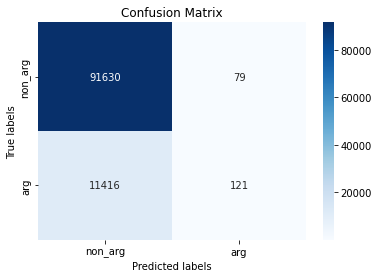

In [ ]:
confusion_mtrx(y_test,y_pred)

##BASELINE ONLY TOKEN WITH ENCODED TOKENS [spoiler, it sucks]

In [ ]:
tokens_train=train[["token","target"]]
tokens_test=test[["token","target"]]
tokens_train=make_binary_label(tokens_train)
tokens_test=make_binary_label(tokens_test)


In [ ]:
tokens_train = tokens_train.drop(tokens_train[tokens_train['label']==0].sample(n=820000).index)


In [ ]:
le = LabelEncoder()
y_all = np.concatenate([tokens_train['token'], tokens_test['token']], axis=0)

# Fit the label encoder to the targets
le.fit(y_all)


# Encode training data x & y
X_train =pd.DataFrame( le.transform(tokens_train['token']),columns=['token'])
X_test =pd.DataFrame(le.transform( tokens_test['token']),columns=['token'])
y_train = tokens_train['label']
y_test = tokens_test['label']


In [ ]:
pred = logistic_reg(X_train,X_test,y_train,y_test)

In [ ]:
f1 = f1_score(y_test,pred)
print(f"{f1=}")

f1=0.0


In [ ]:
pred.sum()

0

##LETS DOWN SAMPLE 

first the first N rows are considered

In [ ]:
sample_size =  [x for x in range(50000,250000,10000)] +[300000,400000,500000,700000,1035928]
sample_size

[50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 110000,
 120000,
 130000,
 140000,
 150000,
 160000,
 170000,
 180000,
 190000,
 200000,
 210000,
 220000,
 230000,
 240000,
 300000,
 400000,
 500000,
 700000,
 1035928]

In [ ]:
f1_scores=[]
true_predicts=[]
for x in sample_size:
  print(f"{x=}")
  tokens_train=train[["token","target"]][:x]
  tokens_test=test[["token","target"]]
  tokens_train=make_binary_label(tokens_train)
  tokens_test=make_binary_label(tokens_test)
  X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)
  y_pred=logistic_reg(X_train,X_test,y_train,y_test)
  predicted_true=y_pred.sum()
  true_predicts.append(predicted_true)
  print(f"{predicted_true=}")
  f1 = f1_score(y_test,y_pred)
  f1_scores.append(f1)
  print(f"{f1=}")
  print("=====\n")

x=50000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=659
f1=0.03820924893407675
=====

x=60000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=791
f1=0.04558728098637249
=====

x=70000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=725
f1=0.04730060349045832
=====

x=80000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=795
f1=0.05108660395718457
=====

x=90000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=802
f1=0.0513817975524759
=====

x=100000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=817
f1=0.053100210458151206
=====

x=110000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=827
f1=0.05435134260757037
=====

x=120000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=769
f1=0.05103201690232407
=====

x=130000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=734
f1=0.04938472822100889
=====

x=140000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=801
f1=0.05008915545469282
=====

x=150000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=769
f1=0.051682106289614824
=====

x=160000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=763
f1=0.05138211382113821
=====

x=170000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=792
f1=0.049314624057101145
=====

x=180000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=743
f1=0.050814332247557
=====

x=190000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=718
f1=0.04863321093431253
=====

x=200000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=733
f1=0.048573757131214354
=====

x=210000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=605
f1=0.043485422500411805
=====

x=220000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=576
f1=0.04391975563444234
=====

x=230000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=638
f1=0.04632443531827515
=====

x=240000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=545
f1=0.04171494785631519
=====

x=300000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=308
f1=0.029886027859856484
=====

x=400000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=261
f1=0.02542803865061875
=====

x=500000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=246
f1=0.024102520580497326
=====

x=700000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=246
f1=0.023932784520071287
=====

x=1035928
predicted_true=200
f1=0.02061855670103093
=====



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
sample_size,f1_scores,true_predicts

([50000,
  60000,
  70000,
  80000,
  90000,
  100000,
  110000,
  120000,
  130000,
  140000,
  150000,
  160000,
  170000,
  180000,
  190000,
  200000,
  210000,
  220000,
  230000,
  240000,
  300000,
  400000,
  500000,
  700000,
  1035928],
 [0.03820924893407675,
  0.04558728098637249,
  0.04730060349045832,
  0.05108660395718457,
  0.0513817975524759,
  0.053100210458151206,
  0.05435134260757037,
  0.05103201690232407,
  0.04938472822100889,
  0.05008915545469282,
  0.051682106289614824,
  0.05138211382113821,
  0.049314624057101145,
  0.050814332247557,
  0.04863321093431253,
  0.048573757131214354,
  0.043485422500411805,
  0.04391975563444234,
  0.04632443531827515,
  0.04171494785631519,
  0.029886027859856484,
  0.02542803865061875,
  0.024102520580497326,
  0.023932784520071287,
  0.02061855670103093],
 [659,
  791,
  725,
  795,
  802,
  817,
  827,
  769,
  734,
  801,
  769,
  763,
  792,
  743,
  718,
  733,
  605,
  576,
  638,
  545,
  308,
  261,
  246,
  246,
  20

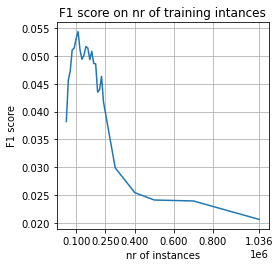

In [ ]:
plt.plot(sample_size,f1_scores)
# set the basic properties
plt.xlabel("nr of instances")
plt.ylabel("F1 score")
plt.title("F1 score on nr of training intances")
plt.xticks([100000,250000, 400000,600000,800000,1035928])
plt.rcParams['figure.figsize'] = [3.8,3.8]
#plt.xlim(0, 100e+4)

# set the grid on
plt.grid('on')


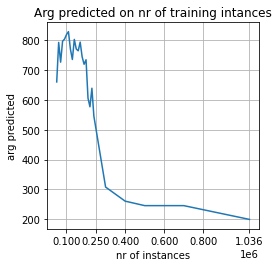

In [ ]:
plt.plot(sample_size,true_predicts)
plt.xlabel("nr of instances")
plt.ylabel("arg predicted")
plt.title("Arg predicted on nr of training intances")
plt.xticks([100000,250000, 400000,600000,800000,1035928])
plt.rcParams['figure.figsize'] = [3.8,3.8]
#plt.xlim(0, 100e+4)

# set the grid on
plt.grid('on')



##Now lets down sample the negative class only

In [ ]:
down_sample_size =  [x for x in range(500000,900000,10000)] 

down_sample_size

[500000,
 510000,
 520000,
 530000,
 540000,
 550000,
 560000,
 570000,
 580000,
 590000,
 600000,
 610000,
 620000,
 630000,
 640000,
 650000,
 660000,
 670000,
 680000,
 690000,
 700000,
 710000,
 720000,
 730000,
 740000,
 750000,
 760000,
 770000,
 780000,
 790000,
 800000,
 810000,
 820000,
 830000,
 840000,
 850000,
 860000,
 870000,
 880000,
 890000]

In [ ]:
f1_scores=[]
true_predicts=[]
n_samples=[]
for x in down_sample_size:
  print(f"{x=}")
  tokens_train=train[["token","target"]]
  tokens_test=test[["token","target"]]
  tokens_train=make_binary_label(tokens_train)
  tokens_test=make_binary_label(tokens_test)

  tokens_train = tokens_train.drop(tokens_train[tokens_train['label']==0].sample(n=x).index)
  n_samples.append(tokens_train.shape[0])
  print(tokens_train.shape[0])
  X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)
  y_pred=logistic_reg(X_train,X_test,y_train,y_test)
  
  predicted_true=y_pred.sum()
  true_predicts.append(predicted_true)
  print(f"{predicted_true=}")

  f1 = f1_score(y_test,y_pred, average='eighted')
  f1_scores.append(f1)
  print(f"{f1=}")
  print("=====\n")

## PREPARE RESULTS baseline1  to give to baseline2 

In [ ]:
tokens_train=train[["token","target"]]
tokens_test=test[["token","target"]]

tokens_train=make_binary_label(tokens_train)
tokens_test=make_binary_label(tokens_test)


In [ ]:
#x=820000
tokens_train = tokens_train.drop(tokens_train[tokens_train['label']==0].sample(n=820000).index)


In [ ]:
X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)

In [ ]:
log_regression = LogisticRegression(penalty='l2')

#fit the model using the training data
log_regression.fit(X_train,y_train)

#use model to make predictions on test data
y_train_pred = log_regression.predict(X_train)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
clean_train=pd.concat([tokens_train['token'].reset_index(drop=True),tokens_train['target'].reset_index(drop=True),pd.DataFrame(data=y_train_pred,columns=['predictions'])],axis=1)

In [ ]:
y_pred = log_regression.predict(X_test)

0

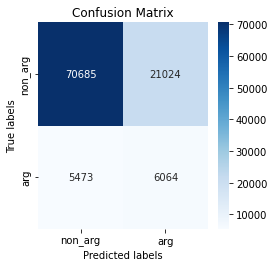

In [ ]:
confusion_mtrx(y_test,y_pred)

In [ ]:
f1_score(y_test,y_pred)

0.3139935275080906

##----------------------------------

##ONLY SOME CATHEGORICAL and numreical FEATURES

WHAT I am doing is trying fist the downsample study on these featurees and then try to add the tokens


It is fair to assume that the more feature there are the less the model is biased by the unbalanced distribution of classes! Thus heavy downsamples for baseline and less and less for more features.. but it would be appropriate to check for every combination of features.

In [250]:
def create_label_encoding(train_df,test_df,cols_to_encode):
  """This function creates a label encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a LabelEncoder objec
  le = LabelEncoder()
  #train_df = oe.fit_transform(df_train[cols_to_encode])
  #test_df = oe.transform(df_test[cols_to_encode])
  #print(oe.categories_)
  # iterate over the columns to encode
  for col in cols_to_encode:
    #print(col)
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])

  return train_df,test_df


def columns_cleaning(df): #political choices inside
  df=df[df["distance_head"]!="_"]#like this
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
  
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE

  df= df.drop('token_id', axis=1) #or this
  """df=df[['sent_id', 'repetion_id','POS', 'uni_POS', 
        'distance_head', 'dep_label','dep_rel','space','morph_type', 'probbank', 'label']]"""

  return df

In [333]:
cols=['sent_id', 'token_id', 'POS', 'uni_POS', #CHANGE THIS BASED ON EXPERIMENT
       'distance_head', 'dep_label', 'target',
       'repetion_id']
ttrain=train[cols]
ttest=test[cols]

ttrain=make_binary_label(ttrain)
ttest=make_binary_label(ttest)
train_targets=ttrain.pop('target') #WE KEEPP THE TARGETS FOR THE NEXT MODEL, BUT WE DROP THEM FOR THE TEST
ttest= ttest.drop('target', axis=1)

#ttrain=downsample(ttrain,N)
ttrain=columns_cleaning(ttrain)
ttest=columns_cleaning(ttest)

cols=[ 'POS', 'uni_POS','dep_label']
ttrain,ttest = create_label_encoding(ttrain,ttest,cols)

<ipython-input-250-309f27169f89>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
<ipython-input-250-309f27169f89>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE


In [335]:
ttest.label.sum()

11536

In [ ]:
n_samples,f1_scores,true_predicts=downsampling_study(ttrain,ttest)

with weighted average the score is less indicative becuse we are taking into consideration also the Non args which raises the score.
Before, with f1 set on the arg class (default), you would have seen a decrease of score with many instance

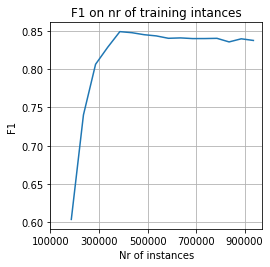

In [331]:
plot_downsampling_study(n_samples,f1_scores,"F1") #THIS IS F1 with weighted average!! 

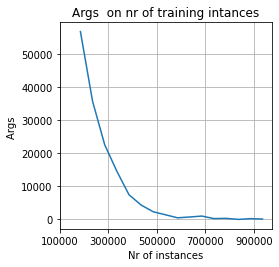

In [332]:
plot_downsampling_study(n_samples,true_predicts,"Args ")

0

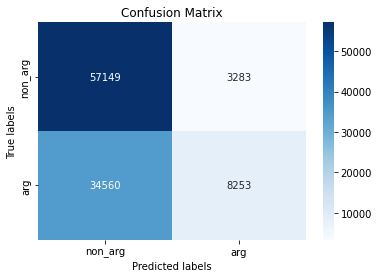

In [191]:
confusion_mtrx(y_pred,y_test)

##TRYING TO MERGE TOKENS AND SOME CATHEGORICAL AND **NUMERICL**

In [18]:

def columns_cleaning(df): #political choices inside
  df=df[df["distance_head"]!="_"]#like this
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
  
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE

  df= df.drop('token_id', axis=1) #or this
  """df=df[['sent_id', 'repetion_id','POS', 'uni_POS', 
        'distance_head', 'dep_label','dep_rel','space','morph_type', 'probbank', 'label']]"""

  return df

In [19]:
cols=['token','sent_id', 'token_id', 'POS', 'uni_POS', #CHANGE THIS BASED ON EXPERIMENT
       'distance_head', 'dep_label', 'target',
       'repetion_id']
ttrain=train[cols].copy()
ttest=test[cols].copy()

ttrain=make_binary_label(ttrain)
ttest=make_binary_label(ttest)
train_targets=ttrain.pop('target') #WE KEEPP THE TARGETS FOR THE NEXT MODEL, BUT WE DROP THEM FOR THE TEST
ttest= ttest.drop('target', axis=1)

train=downsample(ttrain,N)
ttrain=columns_cleaning(ttrain)
ttest=columns_cleaning(ttest)

cols=[ 'POS', 'uni_POS','dep_label']
ttrain,ttest = create_label_encoding(ttrain,ttest,cols)

<ipython-input-18-11a34d94d6c5>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
<ipython-input-18-11a34d94d6c5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE


In [20]:
totrain,totest = vectorize_tfidf_token(ttrain,ttest)

In [21]:
totrain.shape

(1035904, 15936)

In [22]:
totrain=totrain.toarray()
totest=totest.toarray()


In [23]:
col1=np.array(ttrain['POS'].values).reshape(-1,1)
col1.shape

(1035904, 1)

In [24]:
totrain.shape

(1035904, 15936)

In [ ]:
totrain=np.concatenate((totrain,col1),axis=1)

In [15]:
tokdf=pd.DataFrame(toktraindense)

In [16]:
#complete=pd.concat([tokdf,ttrain['POS']])

In [17]:
tokdf['POS']=ttrain['POS']
tokdf['uni_POS']=ttrain['uni_POS']
tokdf['dep_label']=ttrain['dep_label']

In [20]:
toktestdense=totest.toarray()
tokdf_test=pd.DataFrame(toktestdense)

In [22]:
tokdf_test['POS']=ttest['POS']
tokdf_test['uni_POS']=ttest['uni_POS']
tokdf_test['dep_label']=ttest['dep_label']

In [28]:
X_train=tokdf
y_train=ttrain['label']
X_test=tokdf_test
y_test=ttest['label']

In [ ]:
y_pred=logistic_reg(X_train,X_test,y_train,y_test)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [ ]:
f1 = f1_score(y_test,y_pred)


##COLUMNT TRANSFORMER ATTEMPT (ignore)

In [22]:
cols=['token','POS','target']


ctest=test[cols]
ctrain=train[cols]

ctrain=make_binary_label(ctrain)
ctest=make_binary_label(ctest)

ctrain=downsample(ctrain,N)




In [23]:
ctrain

,token,POS,target,label
5,forces,NOUN,ARG0,1
7,Shaikh,PROPN,ARG1,1
17,mosque,NOUN,ARGM-LOC,1
23,",",PUNCT,_,0
26,Syrian,ADJ,_,0
...,...,...,...,...
7077903,since,SCONJ,_,0
7077905,have,AUX,_,0
7077906,graduated,VERB,_,0
7077908,i,PRON,ARG0,1


In [24]:
ctest=ctest.values

In [27]:
ctrain=ctrain.values

In [25]:
ct = ColumnTransformer([("token_vec", CountVectorizer(), 0)], remainder="passthrough",sparse_threshold=0)

totest=ct.fit_transform(ctest)

In [ ]:
totrain=ct.fit_transform(ctrain)

In [350]:
t=totrain.toarray()

In [351]:
t.shape

(1035928, 15936)

In [348]:
# wrap in ColumnTransformer
ct = ColumnTransformer([("token_vec", CountVectorizer(), ["token"])], remainder="passthrough",sparse_threshold=0)

# second pipeline
pipeline = Pipeline(steps=[('ct', ct)])

X_test = pipeline.fit_transform(ctest)

ValueError: ignored

In [337]:
ctest = ct.fit_transform(test)

ValueError: ignored

In [329]:
test

,token,sent_id,token_id,POS,uni_POS,distance_head,dep_label,target,repetion_id
0,What,0,1,PRON,WP,0,root,_,0
1,if,0,2,SCONJ,IN,4,mark,_,0
2,Google,0,3,PROPN,NNP,4,nsubj,ARG1,0
3,Morphed,0,4,VERB,VBD,1,advcl,V,0
4,Into,0,5,ADP,IN,6,case,_,0
...,...,...,...,...,...,...,...,...,...
445063,attended,1463,61,VERB,VBN,58,xcomp,V,17
445064,to,1463,62,ADP,IN,61,obl,C-ARG1,17
445065,RIGHT,1463,63,ADV,RB,64,advmod,_,17
445066,AWAY,1463,64,ADV,RB,61,advmod,ARGM-TMP,17


In [ ]:
dataset.shape

(103246, 4881)

## DICT VECTORIZER
